## Simulating large ciphertexts
In homomorphic encryption (HE), the tile (ciphertext) size depends on several parameters such as the required multiplication depth, security parameter, and precision. In some cases, we are lucky and a plaintext input fits entirely in a tile. As an example, consider NN inference over [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) images of size $32 \times 32 \times 3=3{,}072$, which fit nicely in a ciphertext of $4{,}096$ slots. However, this is not always the case, e.g., when considering the [Imagenet](https://www.image-net.org/) dataset with images of size $224 \times 224 \times 3=150{,}528$. Here, the designer of an HE solution would need to carefully think about how to pack these large images into small ciphertexts with e.g., $32{,}768$ slots. The trivial way is to use a large enough ciphertext. However, when the evaluation circuit is shallow, this can be too slow.

With tile tensors, we can simulate large ciphertexts using smaller ciphertexts while achieving better performance. Thus, we can choose the packing that mostly fits our design assuming the largest ciphertext possible, and subsequently simulate it automatically using smaller ciphertexts. For that, we introduce the concept of interleaved packing, which we describe below. 

To demonstrate the simulation idea we start by observing the statistics of running several simple operations (addition/multiplication/rotation) on a ciphertext that holds an entire vector of 4 slots. Subsequently, we will consider an input vector of 12 elements for the same ciphertext size.

As always we start by importing relevant libraries and [pyhelayers](https://ibm.github.io/helayers/)

In [ ]:
import numpy as np
import pyhelayers

print("Imported pyhelayers", pyhelayers.VERSION)

pyhelayers.get_print_options().tt_demo_tiles=True

# Initialize a mockup context with 4 slots. 
requirement = pyhelayers.HeConfigRequirement.insecure(
    num_slots = 4, # Number of slots per ciphertext
    multiplication_depth = 3, # Allow 3 levels of multiplications
    fractional_part_precision = 40, # Set the precision to 1/2^40.
    integer_part_precision = 20
    )

# Use a mockup HE context and initialize it with the requirements object above.
he_context = pyhelayers.MockupContext()
he_context.init(requirement)
print("Initialized a context with ", he_context.slot_count(), " slots")

# Create the Encoder using the context.
encoder = pyhelayers.TTEncoder(he_context)

### Step 1. An Input vector that fits inside a ciphertext

We start by generating a vector $[1,\ldots,4]$ that fits inside a ciphertext of 8 slots.

In [ ]:
# Set an array [1,...,4]
simple_array   = np.arange(start=1,stop=4+1,step=1).reshape(1,4)

shape          = pyhelayers.TTShape([1,4])
c_simple_array = encoder.encode_encrypt(shape, simple_array)

print(c_simple_array)

#### Addition

As expected we only perform one copy and one addition when running the `add` operation on this tile tensor.

In [ ]:
he_context.start_operation_count_track()

out = c_simple_array.get_add(c_simple_array)
stats = he_context.get_stats_and_clear()

print("Stats after addition,", stats, "\nCurrent TT:", out)

#### Multiplication

Similarly with multiplication, we only perform one multiplication operation that comes together with one `relinearize` and one `rescale` operations. 

In [ ]:
he_context.start_operation_count_track()

out = c_simple_array.get_multiply(c_simple_array)
stats = he_context.get_stats_and_clear()

print("Stats after multiplication,", stats, "\nCurrent TT:", out)

### Rotation

Finally, we observe that only one (left) rotation is performed along the second axis, because there is only one ciphertext.

In [ ]:
he_context.start_operation_count_track()

# Rotate (left) by 1 over dimension 1
c_simple_array.rotate_along_dim(1,1)
stats = he_context.get_stats_and_clear()

print("Stats after multiplication,", stats, "\nCurrent TT:", c_simple_array)

### Step 2 Too-wide vector

Until here we saw that when the input vector fits nicely in a ciphertext the number of (addition/multiplication/rotation) operations is expected. However, what happens when the input vector is larger than the ciphertext size?

We repeat the same experiment as above for the `addition` and `multiplication` operations over a tile tensor that packs a vector of 12 elements, i.e., that fits in three ciphertexts. As expected the number of operations is tripled. However, this is not necessarily a problem. For example, the multiplication operation often involves the NTT operation which runs in $O(n \log(n))$, where $n$ is the ciphertext polynomial degree. This means that while we increase the number of operations linearly we in fact reduced their overall complexity.

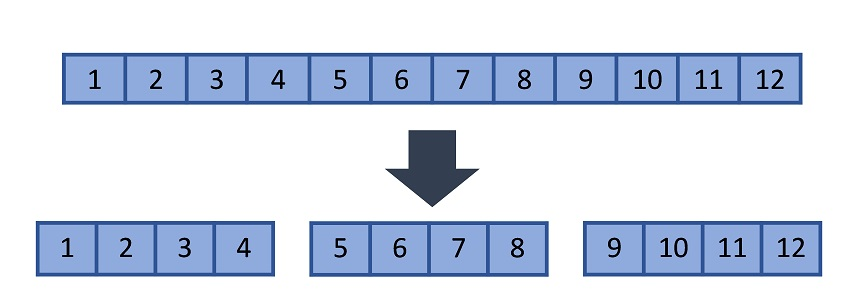


In [ ]:
# Set an array [1,...,12]
too_wide_array   = np.arange(start=1,stop=12+1,step=1).reshape(1,12)

shape          = pyhelayers.TTShape([1,4])
c_too_wide_array = encoder.encode_encrypt(shape, too_wide_array)

print(c_too_wide_array)

#### Addition

In [ ]:
he_context.start_operation_count_track()

out = c_too_wide_array.get_add(c_too_wide_array)
stats = he_context.get_stats_and_clear()

print("Stats after addition,", stats, "\nCurrent TT:", out)

#### Multiplication

In [ ]:
he_context.start_operation_count_track()

out = c_too_wide_array.get_multiply(c_too_wide_array)
stats = he_context.get_stats_and_clear()

print("Stats after multiplication,", stats, "\nCurrent TT:", out)

#### Rotation

The rotation operation is trickier as it requires rotating every ciphertext while also moving elements between ciphertexts. A naive implementation may therefore require 3 rotations 6 multiplications by plaintext masks 6 `rescale` operations and 3 additions, see figure and code.

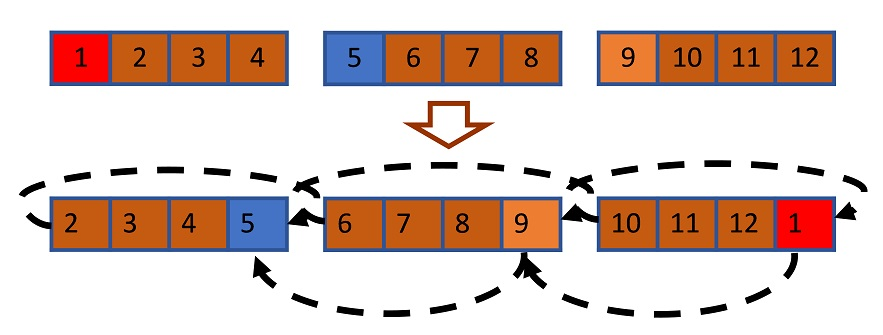


In [ ]:
# Creating the masks, these can be done in advance and thus we don't count it in the statistics below.
mask0 = np.array([0,0,0,1,0,0,0,1,0,0,0,1]).reshape((1,12))
mask0 = encoder.encode(shape, mask0)

mask1 = np.array([1,1,1,0,1,1,1,0,1,1,1,0]).reshape((1,12))
mask1 = encoder.encode(shape, mask1)

# Start counting operations
he_context.start_operation_count_track()

# Get the 3 tiles.
tile0 = c_too_wide_array.get_tile_at((0,0))
tile1 = c_too_wide_array.get_tile_at((0,1))
tile2 = c_too_wide_array.get_tile_at((0,2))

# Rotate every tile
tile0.rotate(1)
tile1.rotate(1)
tile2.rotate(1)

out0 = c_too_wide_array.get_multiply_plain(mask0)
out1 = c_too_wide_array.get_multiply_plain(mask1)

out1.get_tile_at((0,0)).add(out0.get_tile_at((0,1)))
out1.get_tile_at((0,1)).add(out0.get_tile_at((0,2)))
out1.get_tile_at((0,2)).add(out0.get_tile_at((0,0)))

stats = he_context.get_stats_and_clear()
print(stats)

print(out1)

### Using interleaved packing

The interleaved packing was introduced in
> Ehud Aharoni, Allon Adir, Moran Baruch, Nir Drucker, Gilad Ezov, Ariel Farkash, Lev Greenberg, Ramy Masalha, Guy Moshkowich, Dov Murik, Hayim Shaul, and Omri Soceanu. 2020. HeLayers: A Tile Tensors Framework for Large Neural Networks on Encrypted Data. PoPETs 2023.

It was used to accelerate convolutional layer in NNs. The figure below shows how it is applied to vectors. In tile tensor notation an interleaved dimension is marked with `~`. Thus, the tile tensor shape in the example below is $\left[\frac{1}{1}, \frac{12\sim{}}{4} \right]$

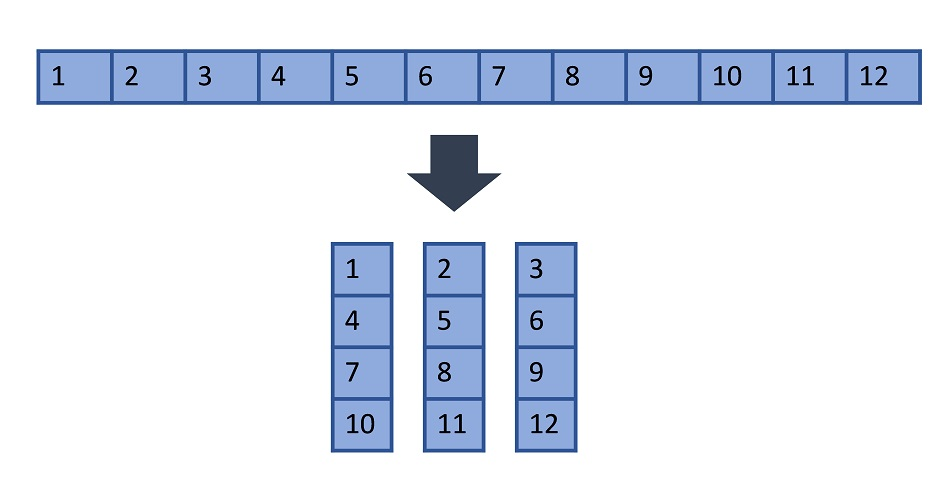

In [ ]:
# Create a shape with the second dimension interleaved
too_wide_array = np.arange(start=1,stop=12+1,step=1).reshape(1,12)

shape=pyhelayers.TTShape([1,4])
shape.get_dim(1).set_interleaved(True)

# Encode-encrypt vector
c_too_wide_array = encoder.encode_encrypt(shape,too_wide_array)
print(c_too_wide_array)

#### Addition
We start by observing that by packing the vector in this way we do not increase the number of additions and multiplications.

In [ ]:
he_context.start_operation_count_track()

out = c_too_wide_array.get_add(c_too_wide_array)
stats = he_context.get_stats_and_clear()

print("Stats after addition,", stats, "\nCurrent TT:", out)

#### Multiplication

In [ ]:
he_context.start_operation_count_track()

out = c_too_wide_array.get_multiply(c_too_wide_array)
stats = he_context.get_stats_and_clear()

print("Stats after multiplication,", stats, "\nCurrent TT:", out)

#### Rotation
In contrast, the number of rotations is reduced to 2 and multiplications are required. Specifically we use the following rotation algorithm:

1. Virtually move a ciphertext or ciphertexts (left figure).
2. Rotate the last ciphertext (right figure).

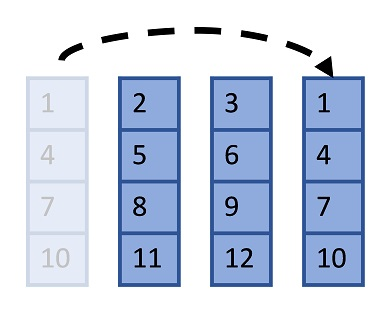 and
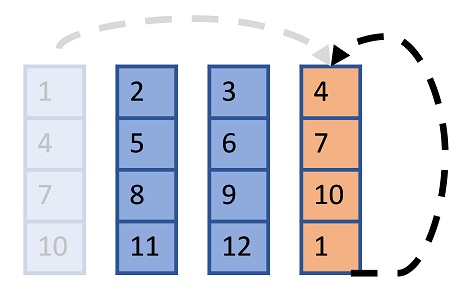

In [ ]:
he_context.start_operation_count_track()

# Rotate (left) by 1 over dimension 1
c_too_wide_array.rotate_along_dim(1,1)
stats = he_context.get_stats_and_clear()

print("Stats after multiplication,", stats, "\nCurrent TT:", c_too_wide_array)

# Sanity check
res=encoder.decrypt_decode_double(c_too_wide_array)
assert (res==[2,3,4,5,6,7,8,9,10,11,12,1]).all()

Question: how many rotations are needed for rotate by 2?  
<details><summary> Answer </summary>2</details>
Question: how many rotations are needed for rotate by 1 and 2?  
<details><summary> Answer </summary>2</details>
Question: how many rotations are needed for rotate by 5?  
<details><summary> Answer </summary>3</details>
Question: what is the maximal number of rotations needed?  
<details><summary> Answer </summary>3</details>

NOTE: you can check your answers using the cell above.


## Summary

The demonstration above shows that we have a strong incentive to use ciphertexts that are as small as possible. This improves performance on several accounts:

* The number of additions and multiplications grows linearly with the number of ciphertexts, but smaller ciphertexts are more efficient per slot. So overall time performance improves.
* The number of rotations grows sub-linearly, providing an even greater performance boost.
* Breaking a large task into multiple smaller ones allows more efficient parallelization.

The minimal size of the ciphertexts is usually determined by security and multiplication depth constraints. Using tile tensors we are free to set it using these constraints only, regardless of input size.